# HPC and Parallel computing

## Objectives
* Discuss calculation performance

> Reminder: You should all have started your projects. You should be able to give a simple report over what you are doing and planning to do one week from today.

## Extending Python into a Parallel environment

One thing we have been discussing is how to make our code faster, here we will cover the use of parallelization schemes, by keeping in mind the simple approach. No deep methods will be used, the idea is to give you a simple methodology to use on Python.

When do we care about parallelization?

+ Is my code fast enough to produce the results I need in the time I have

+ How many CPUh is this code going to waste over its lifetime?

+ Does it cause problems on the system it's running on?

+ How much effort is it to make it run faster?


In what follows, it is almost verbatim from https://github.com/NIH-HPC/python-in-hpc

In [35]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import numba
from numba import jit
import sys
import os
%matplotlib inline

To understand what we mean by parallelization, let us start with a very well known problem in computational physics by using "normal python" and we work from there.

We will use the well known Mandelbrot set. The Mandelbrot set is an example of a fractal in mathematics. It is named after **Benoît Mandelbrot**, a Polish-French-American mathematician. The Mandelbrot set is important for chaos theory. The edging of the set shows a self-similarity, which is not perfect because it has deformations. 

Ah.. you do not know what is a fractal... let see.. A geometric fractal is a geometric shape with a repeating structure at different scales: it doesn’t matter whether you get closer to the image or not

In [1]:
# create a tree, we are going to divide each branch into two sub-branches (left and right) and shorten 
# the new sub-branches

import turtle

MINIMUM_BRANCH_LENGTH = 5

# branch_length: the current length of the branch in pixels.
# shorten_by: determines by how many pixels the sub-branches will be shorter than the parent branch.
# angle: the angles from which the sub-branches emerge from the parent branch.

def build_tree(t, branch_length, shorten_by, angle):
    if branch_length > MINIMUM_BRANCH_LENGTH:
        t.forward(branch_length)
        new_length = branch_length - shorten_by
        t.left(angle)
        build_tree(t, new_length, shorten_by, angle)
        t.right(angle * 2)
        build_tree(t, new_length, shorten_by, angle)
        t.left(angle)
        t.backward(branch_length)

# creating the instance of turtle
tree = turtle.Turtle()

tree.hideturtle()

tree.setheading(90)

tree.color('green')

build_tree(tree, 50, 5, 30)

turtle.mainloop()

Terminator: 

In [2]:
import turtle

def koch_curve(t, iterations, length, shortening_factor, angle):
    if iterations == 0:
        t.forward(length)
    else:
        iterations = iterations - 1
        length = length / shortening_factor
        koch_curve(t, iterations, length, shortening_factor, angle)
        t.left(angle)
        koch_curve(t, iterations, length, shortening_factor, angle)
        t.right(angle * 2)
        koch_curve(t, iterations, length, shortening_factor, angle)
        t.left(angle)
        koch_curve(t, iterations, length, shortening_factor, angle)
    
t = turtle.Turtle()
t.hideturtle()
for i in range(3):
    koch_curve(t, 4, 200, 3, 60)
    t.right(120)
turtle.mainloop()

Terminator: 

Now let me go back to Maldelbrot set. It is basically the mapping
$$
Z_{n+1} = Z_n +c
$$
where $Z$ is a complex number. Images are created by applying the equation to each pixel in an iterative process, using the pixel's position in the image for the number 'c' ($x+iy$). 'c' is obtained by mapping the position of the pixel in the image relative to the position of the point on the complex plane.

The following plotting function draws a pretty picture which is a quick way to verify that the results returned by the various mandel_set function implementations are correct. The first argument is a mandel_set function that returns a 2D array(-like) object that can be plotted.

In [3]:
def mandelbrot_image(fun, xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80, cmap='magma'):
    dpi = float(width) / 7.0
    z = fun(xmin, xmax, ymin, ymax, width, height, maxiter)
    
    fig, ax = plt.subplots(figsize=(7,7), dpi=72)
    plt.xticks([])
    plt.yticks([])
    plt.title("[{xmin}, {ymin}] to [{xmax}, {ymax}]".format(**locals()))
    
    norm = colors.PowerNorm(0.3)
    ax.imshow(z,cmap=cmap,origin='lower',norm=norm)

In [4]:
def linspace(start, stop, n):
    step = float(stop - start) / (n - 1)
    return [start + i * step for i in range(n)]

def mandel1(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return n

def mandel_set1(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = linspace(xmin, xmax, width)
    i = linspace(ymin, ymax, height)
    n = [[0]*width for _ in range(height)]
    for x in range(width):
        for y in range(height):
            n[y][x] = mandel1(complex(r[x], i[y]), maxiter)
    return n

We'll use two areas of the Mandelbrot set as benchmarks for the code in this notebook:

the first, (xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80) runs quicker and is used in each section of the notebook

the second (xmin=-0.74877, xmax=-0.74872, ymin=0.06505, ymax=0.06510, width=1000, height=1000, maxiter=2048) requires considerable more compute time.

Other sets covering the same area as set2 but at a higher resolution may be used in some circumstances

In [5]:
%timeit mandel_set1()

4.39 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit mandel_set1(xmin=-0.74877, xmax=-0.74872, ymin=0.06505, ymax=0.06510, width=1000, height=1000, maxiter=2048)

1min 28s ± 2.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


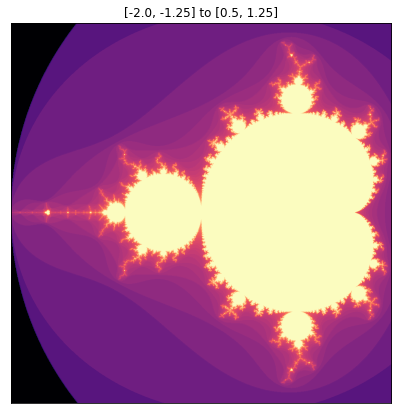

In [7]:
mandelbrot_image(mandel_set1)

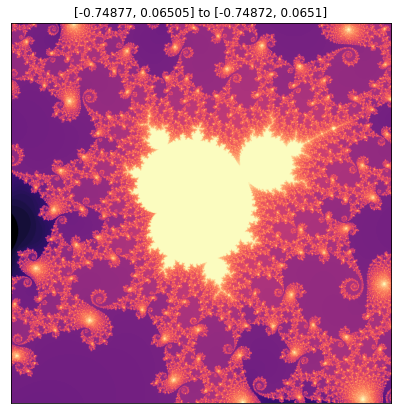

In [8]:
mandelbrot_image(mandel_set1, -0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

In [9]:
# this was too long
# Let us profile the code
p = %prun -r -q mandel_set1()
p.stream = sys.stdout
p.sort_stats('cumulative').print_stats(5)

          25214601 function calls in 6.987 seconds

   Ordered by: cumulative time
   List reduced from 9 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.987    6.987 {built-in method builtins.exec}
        1    0.002    0.002    6.987    6.987 <string>:1(<module>)
        1    0.510    0.510    6.986    6.986 <ipython-input-4-2accf7202ab4>:13(mandel_set1)
  1000000    4.946    0.000    6.471    0.000 <ipython-input-4-2accf7202ab4>:5(mandel1)
 24214592    1.526    0.000    1.526    0.000 {built-in method builtins.abs}




In [10]:
# simpler but with less control
%prun -s cumulative mandel_set1()

In [11]:
# Most of the time in mandel
%load_ext line_profiler

In [12]:
%lprun -f mandel1 mandel_set1()

If you check the output, you will see that most of the time in this function is spent on calculating the absolute value and the value of the next iteration. Both of those involve redundant steps that can be factored out. Later on we will implement this, but for now let's try the simplest approach.

In [13]:
@jit(nopython=True)
def mandel2(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return n

def mandel_set2(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = linspace(xmin, xmax, width)
    i = linspace(ymin, ymax, height)
    n = [[0]*width for _ in range(height)]
    for x in range(width):
        for y in range(height):
            n[y][x] = mandel2(complex(r[x], i[y]), maxiter)
    return n

# warm up jit
_ = mandel_set2()

In [14]:
%timeit mandel_set2()

518 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit mandel_set2(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

3.62 s ± 81.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%prun -s cumulative mandel_set2()

In [17]:
%lprun -f mandel_set2 mandel_set2()


Timer unit: 1e-06 s

Total time: 2.33788 s
File: <ipython-input-13-9aae54ac1ac3>
Function: mandel_set2 at line 10

 Line  #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    10                                           def mandel_set2(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    11         1        263.0    263.0      0.0      r = linspace(xmin, xmax, width)
    12         1        235.0    235.0      0.0      i = linspace(ymin, ymax, height)
    13         1       5844.0   5844.0      0.2      n = [[0]*width for _ in range(height)]
    14      1001        683.0      0.7      0.0      for x in range(width):
    15   1001000     627705.0      0.6     26.8          for y in range(height):
    16   1000000    1703150.0      1.7     72.9              n[y][x] = mandel2(complex(r[x], i[y]), maxiter)
    17         1          1.0      1.0      0.0      return n


In [18]:
#Let see if we can get better performance if we change from Lists to Python vectors
@jit(nopython=True)
def mandel3(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandel_set3(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((height, width), dtype=int)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel3(complex(r[x], i[y]), maxiter)
    return n

# warm up jit
_ = mandel_set3()

In [19]:
%timeit mandel_set3()

866 ms ± 38.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit mandel_set3(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

3.86 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


No it did not - it actually is a bit slower. This might change with larger arrays. But either way, now we can jit compile it.

## Implementation 4: Numba jit compile the second function

Again, the only thing that has to change in the code is the `@jit` decorator. Note that for `np.empty`, `dtype=int` fails

In [21]:
@jit(nopython=True)
def mandel4(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return n

@jit(nopython=True)
def mandel_set4(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((height, width), dtype=np.int32)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel4(complex(r[x], i[y]), maxiter)
    return n

# warm up jit
_ = mandel_set4()

In [22]:
%timeit mandel_set4()

129 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit mandel_set4(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

3.2 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ah - that's better. Now the speedup is ~15-fold. Note: can't line_profile the jit functions

## Implementation 5: Improve the algorithm

The following are the definition of the square of complex numbers, the absolute value, and the sum of two complex numbers:

$$
\begin{aligned}
(a + bi)^2 &= (a + bi)(a + bi) = (a^2 - b^2) + 2abi \\
|a + bi| &= \sqrt{a^2 + b^2} \\
(a + bi) + (c + di) &= (a + c) + (b + d)i
\end{aligned}
$$

Based on this, we can factor out some redundant calculations by passing the real and imaginary parts of the complex numbers directly to the `mandel` function and calculating their squares separately only once and avoiding the square root computation.

In [24]:
@jit(nopython=True)
def mandel5(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2 * real*imag + cimag
        real = real2 - imag2 + creal       
    return n

@jit(nopython=True)
def mandel_set5(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((height, width), dtype=np.int32)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel5(r[x], i[y], maxiter)
    return n

# warm up jit
_ = mandel_set5()

In [25]:
%timeit mandel_set5()

80.6 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit mandel_set5(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

2.09 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


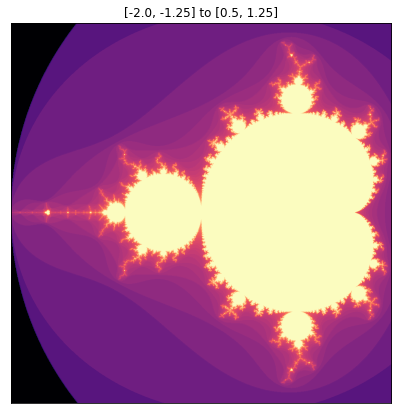

In [27]:
# which is still correct
mandelbrot_image(mandel_set5)

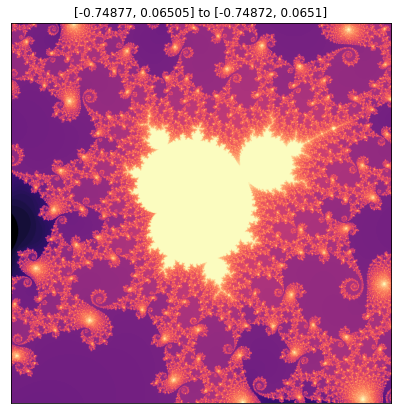

In [28]:
# and the smallest window is
mandelbrot_image(mandel_set5, -0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

## Implementation 6: Cython
Cython is a static compiler for Python plus the Cython extensions such as static type definitions. It generates C code that uses the Python C API to create C extensions.
How does a cythonized version of implementation 5 perform? To conveniently use cython code in a jupyter notebook, we'll load the cython extension first. Under the hood, this will generate C code, compile the extension module, and load it.

In [29]:
%load_ext cython

In [30]:
%%cython
import cython
import numpy as np

cdef int mandel6(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return n

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef mandel_set6(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter):
    cdef:
        double[:] r1 = np.linspace(xmin, xmax, width)
        double[:] r2 = np.linspace(ymin, ymax, height)
        int[:,:] n = np.empty((height, width), np.int32)
        int i,j
    
    for i in range(width):
        for j in range(height):
            n[j,i] = mandel6(r1[i], r2[j], maxiter)
    return n

In [31]:
%timeit mandel_set6(-2.0, 0.5, -1.25, 1.25, 1000, 1000, 80)

83.6 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit mandel_set6(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.13 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


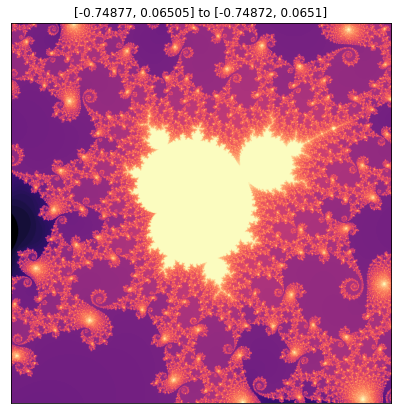

In [33]:
mandelbrot_image(mandel_set6, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048)

## Implementation 7: GPU with pyopencl

Timing with [pyopencl](https://mathema.tician.de/software/pyopencl/) requires a GPU node and the CUDA module loaded on our systems in case it does not run (no in the most recent anaconda). The /etc/OpenCL/vendors/ files had to be copied to the corresponding etc dir in the anaconda tree for the pyopencl conda package to recognize the GPU. We're skipping a CPU pyopencl test.

Note that pyopencl is not the only way to offload computation to a GPU. Numba and pycuda are other possibilities.



In [35]:
import pyopencl as cl
platforms = cl.get_platforms()
print(platforms)
ctx = cl.Context(
        dev_type=cl.device_type.ALL,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])

[<pyopencl.Platform 'Apple' at 0x7fc244afa260>]


In [36]:
def mandel7(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float real = q[gid].x;
        float imag = q[gid].y;
        output[gid] = maxiter;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real, imag2 = imag*imag;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 return;
            }
            imag = 2* real*imag + q[gid].y;
            real = real2 - imag2 + q[gid].x;
            
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandel_set7(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n = mandel7(c,maxiter)
    n = n.reshape((height, width))
    return n

In [37]:
%timeit mandel_set7(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

The slowest run took 4.03 times longer than the fastest. This could mean that an intermediate result is being cached.
23.5 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit mandel_set7(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

55.8 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


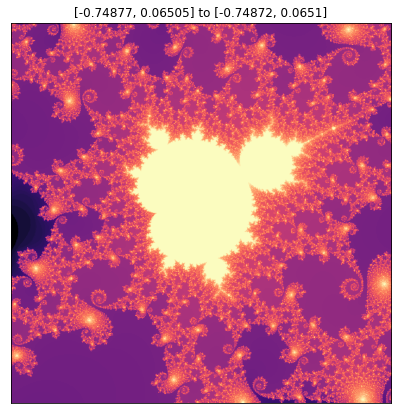

In [39]:
mandelbrot_image(mandel_set7, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048)

## Implementation 8: Fortran

The `f2py` tool included with numpy can be used to bind fortran code to python. I don't have any fortran magic installed, so here is just the fortran code that implements the same algorithm:

In [41]:
%cat mandel08.f90

subroutine mandel_set8(xmin, xmax, ymin, ymax, width, height, itermax, n)
    real(8), intent(in)   :: xmin, xmax, ymin, ymax
    integer, intent(in)   :: width, height, itermax
    integer               :: niter
    integer, dimension(height, width), intent(out) :: n
    integer               :: x, y
    real(8)               :: xstep, ystep
    
    xstep = (xmax - xmin) / (width - 1)
    ystep = (ymax - ymin) / (width - 1)
    do x = 1, width
        do y = 1, height
            call mandel8(xmin + (x - 1) * xstep, ymin + (y - 1) * ystep, itermax, niter)
            n(y, x) = niter
        end do
    end do
end subroutine mandel_set8

subroutine mandel8(cre, cim, itermax, n)
    real(8), intent(in)      :: cre, cim
    integer, intent(in)      :: itermax
    integer, intent(out)     :: n
    real(8)                  :: re2, im2, re, im

    re = cre
    im = cim 
    do n = 0, itermax - 1
        re2 = re ** 2
        im2 = im ** 2
        if (re2 + im2 > 4.0) then
            exit


Which was compiled into the mb_fort module with

     $ f2py -m mb_fort -c mandel08.f90 --fcompiler=gnu95

after which it can be imported


In [42]:
from mb_fort import mandel8, mandel_set8

In [43]:
%timeit mandel_set8(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

77.6 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%timeit mandel_set8(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

1.99 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


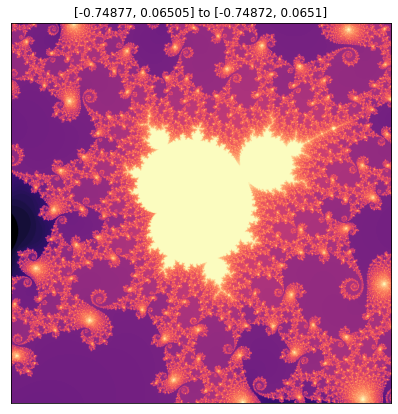

In [45]:
mandelbrot_image(mandel_set8, -0.74877,-0.74872,0.06505,0.06510, maxiter=2048)

## Implementation 9: Multiprocessing

Multiprocessing refers to the ability of a system to support more than one processor at the same time. Applications in a multiprocessing system are broken to smaller routines that run independently. The operating system allocates these threads to the processors improving performance of the system.


**A multiprocessing system can have**:

multiprocessor, i.e. a computer with more than one central processor.

multi-core processor, i.e. a single computing component with two or more independent actual processing units (called “cores”).


The multiprocessing module emphasizes avoiding shared state, so we'll stick with that. For simplicity we'll use python lists to begin with to see how good performance is. Since communication has overhead, we'll break the computation up such that each task returns a row. Note that on linux fork is the default way of starting subprocesses. In that case we can get away with not making the main module safely importable. Generally speaking though it's better to do so.

Now, let me clarify some concepts:

Parallel programming is a broad concept. It can describe many types of processes running on the same machine or on different machines.

Multithreading specifically refers to the concurrent execution of more than one sequential set (thread) of instructions. Let me be more clear. For example, if a processor executes a load instruction, it will generally take multiple clock cycles to get the datum from memory, so the next instruction couldn’t immediately start to use the loaded value. Instead of just waiting for, let’s say 10 clock cycles for the memory access, a multithreaded processor simply starts working on an instruction from another process (another “thread”). In other words, multithreading is the ability of the CPU to execute multiple processes or threads concurrently

In [51]:
# Before we complicate it, let see a very simple example

# importing the multiprocessing module 
import multiprocessing 

#To create a process, we create an object of Process class. It takes following arguments:
#target: the function to be executed by process
#args: the arguments to be passed to the target function
#Note: Process constructor takes many other arguments also which will be discussed later. 
#      In this example, we created 2 processes with different target functions:


  
def print_cube(num): 
    """ 
    function to print cube of given num 
    """
    print("Cube: {}\n".format(num * num * num)) 
  
def print_square(num): 
    """ 
    function to print square of given num 
    """
    print("Square: {}\n".format(num * num)) 
  
if __name__ == "__main__": 
    # creating processes 
    p1 = multiprocessing.Process(target=print_square, args=(10, )) 
    p2 = multiprocessing.Process(target=print_cube, args=(10, )) 
  
    # starting process 1 
    p1.start() 
    # starting process 2 
    p2.start() 
  
    # wait until process 1 is finished 
    p1.join() 
    # wait until process 2 is finished 
    p2.join() 
  
    # both processes finished 
    print("Done!") 

Square: 100

Cube: 1000

Done!


In [52]:
# Now one more complex version

# importing the multiprocessing module 
import multiprocessing 
import os 
  
def worker1(): 
    # printing process id 
    print("ID of process running worker1: {} \n".format(os.getpid())) 
  
def worker2(): 
    # printing process id 
    print("ID of process running worker2: {} \n".format(os.getpid())) 
  
if __name__ == "__main__": 
    # printing main program process id 
    print("ID of main process: {} \n".format(os.getpid())) 
  
    # creating processes 
    p1 = multiprocessing.Process(target=worker1) 
    p2 = multiprocessing.Process(target=worker2) 
  
    # starting processes 
    p1.start() 
    p2.start() 
  
    # process IDs 
    print("ID of process p1: {}".format(p1.pid)) 
    print("ID of process p2: {}".format(p2.pid)) 
  
    # wait until processes are finished 
    p1.join() 
    p2.join() 
  
    # both processes finished 
    print("Both processes finished execution!") 
  
    # check if processes are alive 
    print("Process p1 is alive: {}".format(p1.is_alive())) 
    print("Process p2 is alive: {}".format(p2.is_alive())) 

ID of main process: 82051 

ID of process running worker1: 88972 

ID of process running worker2: 88973 

ID of process p1: 88972
ID of process p2: 88973
Both processes finished execution!
Process p1 is alive: False
Process p2 is alive: False


In [53]:
# execution of a function across multiple input values, distributing the input data across processes i.e. 
# data based parallelism

from multiprocessing import Pool

def func(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(func, [1, 2, 3]))

[1, 4, 9]


In [55]:
#maybe this example is better

import threading
import time
import random


# function (hello) that prints "Hello!" along with whatever argument is passed
def hello(n):
    time.sleep(random.randint(1,3))
    print("[{0}] Hello! \n".format(n))

for i in range(10):
    threading.Thread(target=hello, args=(i,)).start()

print("Done!")


Done!
[6] Hello! 
[7] Hello! 


[9] Hello! 

[0] Hello! 
[2] Hello! 
[5] Hello! 
[3] Hello! 




[1] Hello! 
[4] Hello! 


[8] Hello! 



In [56]:
#If you want to be sure that "Done!" is printed after all the threads have finished running, 
# you can use join. To do that, you need to grab each instance of threading.Thread, put it in a list, 
# and then invoke join on each thread
def hello(n):
    time.sleep(random.randint(1,3))
    print("[{0}] Hello!".format(n))

threads = [ ]
for i in range(10):
    t = threading.Thread(target=hello, args=(i,))
    threads.append(t)
    t.start()

for one_thread in threads:
    one_thread.join()

print("Done!")


[5] Hello![0] Hello![1] Hello![6] Hello!



[4] Hello![8] Hello!

[9] Hello!
[7] Hello![3] Hello![2] Hello!


Done!


In [57]:
import multiprocessing as mp

ncpus = 1
@jit(nopython=True)
def mandel10(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2 * real*imag + cimag
        real = real2 - imag2 + creal       
    return n

@jit(nopython=True)
def mandel10_row(args):
    y, xmin, xmax, width, maxiter = args
    r = np.linspace(xmin, xmax, width)
    res = [0] * width
    for x in range(width):
        res[x] = mandel10(r[x], y, maxiter)
    return res
        

def mandel_set10(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    i = np.linspace(ymin, ymax, height)
    with mp.Pool(ncpus) as pool:
        n = pool.map(mandel10_row, ((a, xmin, xmax, width, maxiter) for a in i))
    return n

In [58]:
for i in (1, 2, 4, 8, 14):
    ncpus = i
    %timeit mandel_set10(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.49 s ± 60.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.47 s ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.02 s ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.21 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.7 s ± 91.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


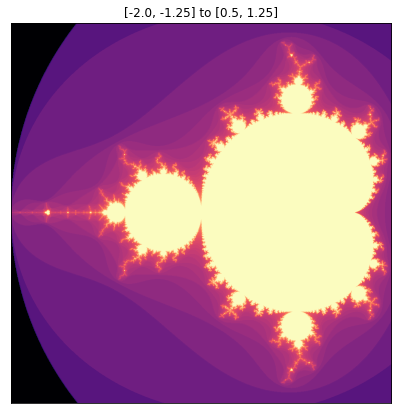

In [59]:
mandelbrot_image(mandel_set10, -2.0, 0.5, -1.25, 1.25)

In [ ]:
mandelbrot_image(mandel_set10, -0.74877,-0.74872,0.06505,0.06510, maxiter=2048)

## Last but no least: MPI

In [3]:
%%writefile testmpi.py

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
print('My rank is ',rank)

Writing testmpi.py


In [4]:
!mpirun -n 4 python testmpi.py

My rank is  1
My rank is  2
My rank is  0
My rank is  3


Now we will look at how to pass data from one process to another. Here is a very simple example where we pass a dictionary from process 0 to process 1:

In [7]:
%%writefile testmpi_pass.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    # in real code, this section might
    # read in data parameters from a file
    numData = 10  
    comm.send(numData, dest=1)

    data = np.linspace(0.0,3.14,numData)  
    comm.Send(data, dest=1)

elif rank == 1:

    numData = comm.recv(source=0)
    print('Number of data to receive: ',numData)

    data = np.empty(numData, dtype='d')  # allocate space to receive the array
    comm.Recv(data, source=0)

    print('data received: ',data)

Overwriting testmpi_pass.py


In [8]:
!mpirun -n 4 python testmpi_pass.py

Number of data to receive:  10
data received:  [0.         0.34888889 0.69777778 1.04666667 1.39555556 1.74444444
 2.09333333 2.44222222 2.79111111 3.14      ]


Now let us try broadcasting

In [9]:
%%writefile testmpi_bdt.py
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'key1' : [1,2, 3],
            'key2' : ( 'abc', 'xyz')}
else:
    data = None

data = comm.bcast(data, root=0)
print('Rank: ',rank,', data: ' ,data)

Writing testmpi_bdt.py


In [10]:
!mpirun -n 4 python testmpi_bdt.py

Rank:  0 , data:  {'key1': [1, 2, 3], 'key2': ('abc', 'xyz')}
Rank:  1 , data:  {'key1': [1, 2, 3], 'key2': ('abc', 'xyz')}
Rank:  2 , data:  {'key1': [1, 2, 3], 'key2': ('abc', 'xyz')}
Rank:  3 , data:  {'key1': [1, 2, 3], 'key2': ('abc', 'xyz')}


In [37]:
%%writefile testmpi_mandel.py

# file: mandelbrot-mpi.py
import numpy as np
from mpi4py import MPI
from matplotlib import pyplot as plt
from matplotlib import colors

def mandelbrot(c, maxit):
    z = c
    for n in range(maxit):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0


xmin,xmax = -2.0, 1.0
ymin,ymax = -1.0, 1.0
width,height = 320,200

maxit = 127

comm = MPI.COMM_WORLD
comm_size = comm.Get_size()
comm_rank = comm.Get_rank()

ncols = width // comm_size + (width % comm_size > comm_rank)
col_start = comm.scan(ncols) - ncols

xlin = np.linspace(xmin, xmax, width)
ylin = np.linspace(ymin, ymax, height)

C_local = np.empty((ncols,height), np.int64)

for w in range(ncols):
    for h in range(height):
        C_local[w, h] = mandelbrot(xlin[w+col_start] + 1j*ylin[h], maxit)

# Gather Results here
comm_gather_num = comm.gather(ncols, root=0)
C = None
if comm_rank == 0:
    C = np.empty((width,height), np.int64)
else:
    C = None
rowtype = MPI.INT64_T.Create_contiguous(height)
rowtype.Commit()

comm.Gatherv(sendbuf=[C_local, MPI.INT64_T],
        recvbuf=[C, (comm_gather_num, None), rowtype],
        root=0)
rowtype.Free()

if comm_rank == 0:
    fig, ax = plt.subplots(figsize=(7,7), dpi=72)
    plt.xticks([])
    plt.yticks([])
    #plt.title("[{xmin}, {ymin}] to [{xmax}, {ymax}]".format(**locals()))
    norm = colors.PowerNorm(0.3)
    ax.imshow(C,origin='lower', cmap='magma', norm=norm)
    #plt.imshow(C, aspect='equal')
    #plt.cm.spectral()
    plt.savefig("MandelParal.png")
    plt.show()

Overwriting testmpi_mandel.py


In [38]:
!mpirun -np 4 python testmpi_mandel.py

Figure(504x504)


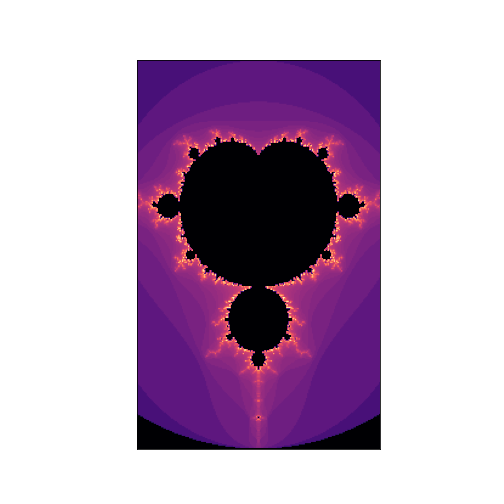